In [1]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)

/home/ladans/DNN/Project
/home/ladans/DNN/Project/Dataset


In [2]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate
from keras.layers import Flatten, RepeatVector

# Directory containing CSV files
data_dir = dir_base

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    # Extract stock symbol from the filename
    stock_symbol = os.path.basename(file_path).split('.')[0]
    
    # Load the CSV
    df = pd.read_csv(file_path)
    
    # Add a column for the stock symbol
    df['Stock_Symbol'] = stock_symbol
    
    # Optional: Select only necessary columns
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    
    # Append to the main DataFrame
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by date and stock symbol if needed
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])
all_data.head()

2024-11-14 16:33:50.586641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731602030.611379  120078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731602030.620837  120078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 16:33:50.647165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Date,Open,Close,Stock_Symbol,Stock_Index
0,2012-09-04,95.108574,96.424286,AAPL,0
1,2012-09-05,96.510002,95.747147,AAPL,0
2,2012-09-06,96.167145,96.610001,AAPL,0
3,2012-09-07,96.864288,97.205711,AAPL,0
4,2012-09-10,97.207146,94.677139,AAPL,0


What was the change in the closing price of the stock overtime?

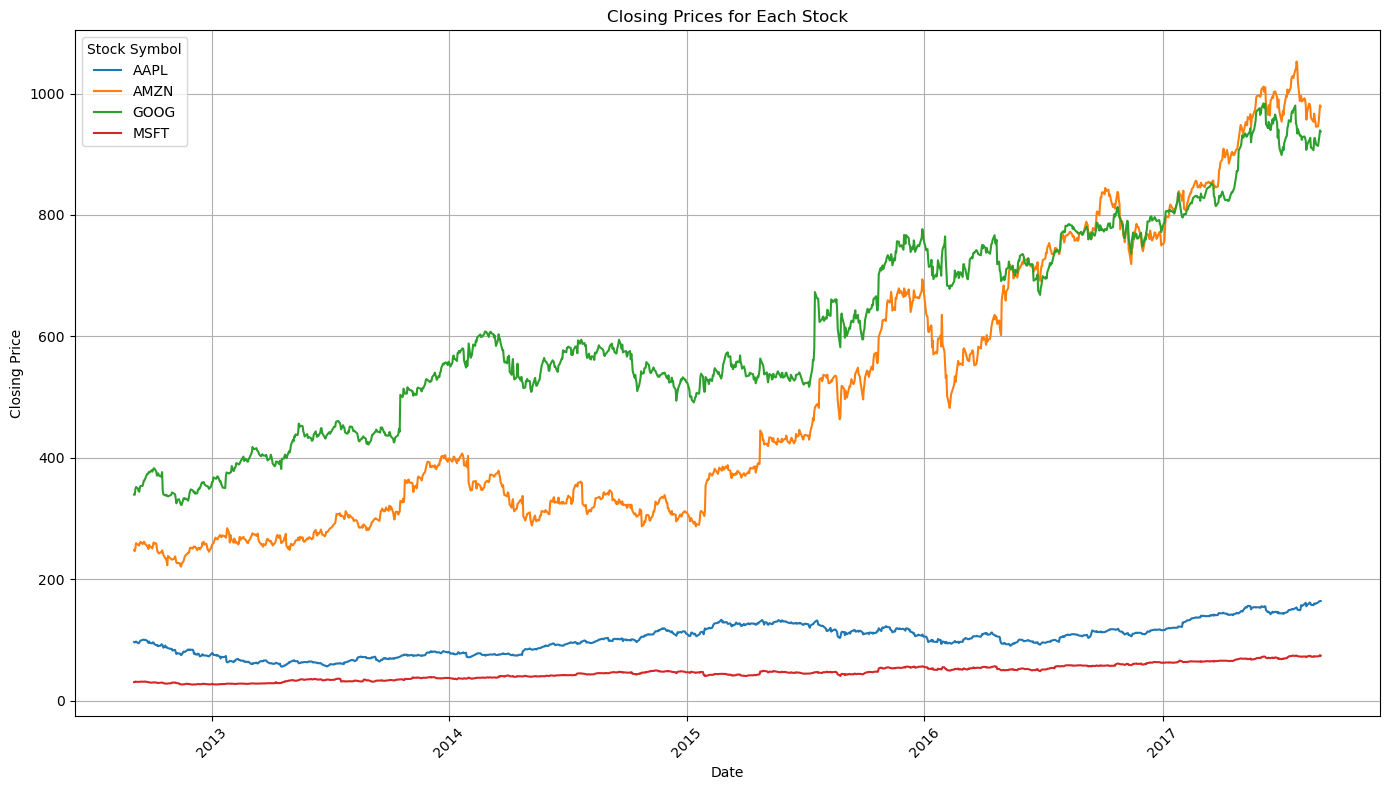

In [6]:
import seaborn as sns

# Ensure the 'Date' column is treated as a datetime type
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=all_data, x='Date', y='Close', hue='Stock_Symbol')

plt.title('Closing Prices for Each Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(title='Stock Symbol', loc='best')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.grid(True)
plt.tight_layout()
plt.savefig('closing_price')
plt.show()


Moving Average

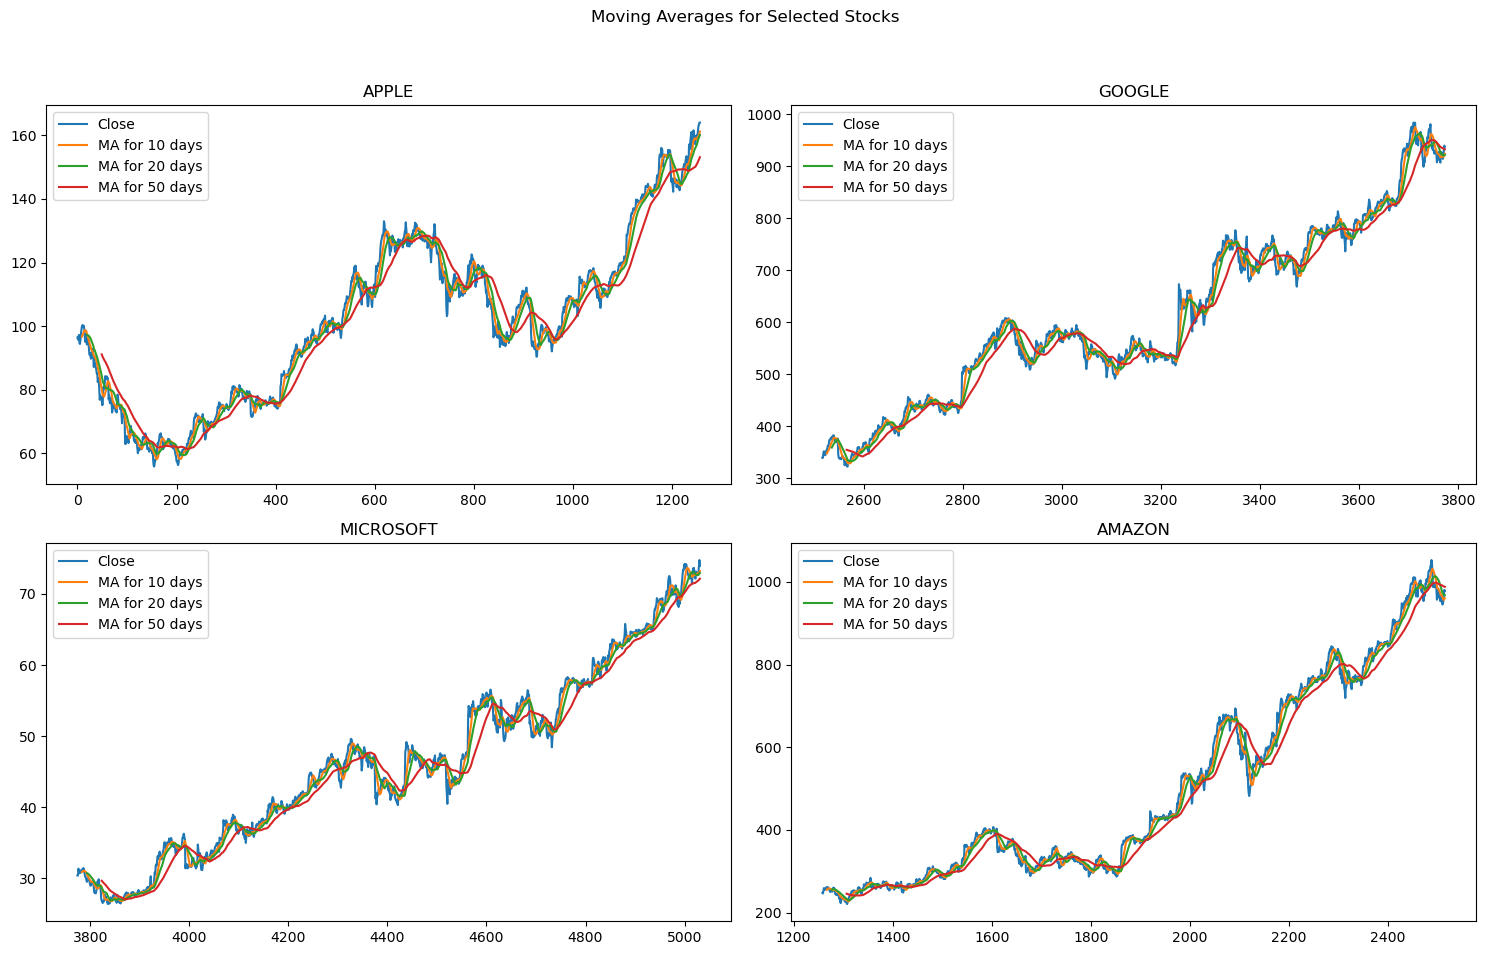

In [10]:
import matplotlib.pyplot as plt

# Define the moving average days
ma_day = [10, 20, 50]

# Dictionary to store individual DataFrames for each company
company_data = {}

# Split the dataset into separate DataFrames for each stock symbol
for company in all_data['Stock_Symbol'].unique():
    company_data[company] = all_data[all_data['Stock_Symbol'] == company].copy()

# Calculate moving averages for each company and add them as columns
for ma in ma_day:
    for company, df in company_data.items():
        column_name = f"MA for {ma} days"
        df[column_name] = df['Close'].rolling(ma).mean()
        company_data[company] = df

# Plot the adjusted close prices and moving averages for each stock
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Moving Averages for Selected Stocks')

# Plot for AAPL
company_data['AAPL'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0, 0])
axes[0, 0].set_title('APPLE')

# Plot for GOOG
company_data['GOOG'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0, 1])
axes[0, 1].set_title('GOOGLE')

# Plot for MSFT
company_data['MSFT'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1, 0])
axes[1, 0].set_title('MICROSOFT')

# Plot for AMZN
company_data['AMZN'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1, 1])
axes[1, 1].set_title('AMAZON')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include title
plt.savefig('moving average')
plt.show()


Correlation between the stocks

Correlation Matrix:
Stock_Symbol      AAPL      AMZN      GOOG      MSFT
Stock_Symbol                                        
AAPL          1.000000  0.739198  0.754817  0.840126
AMZN          0.739198  1.000000  0.955385  0.931662
GOOG          0.754817  0.955385  1.000000  0.965686
MSFT          0.840126  0.931662  0.965686  1.000000


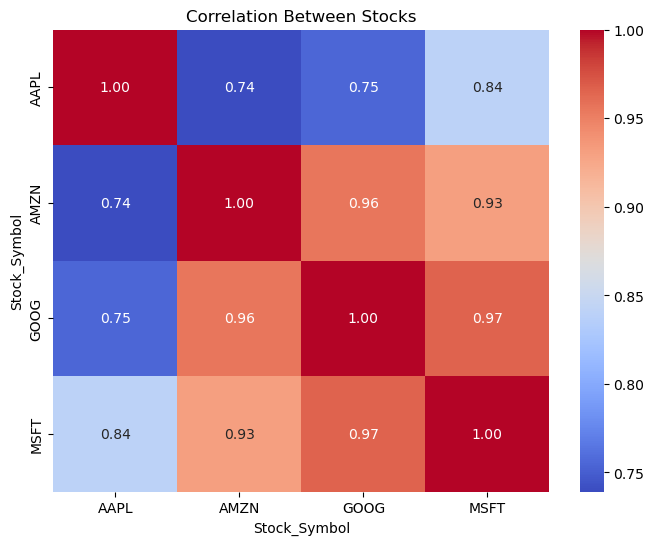

In [12]:
import pandas as pd

# Pivot the data so each stock symbol becomes a column
correlation_data = all_data.pivot(index='Date', columns='Stock_Symbol', values='Close')

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix with a heatmap (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Between Stocks')
plt.savefig('correlations')
plt.show()


Risk Value

In [14]:
import numpy as np
import pandas as pd

# Calculate daily percentage returns for each stock
all_data['Daily Return'] = all_data.groupby('Stock_Symbol')['Close'].pct_change() * 100

# Group by stock symbol to calculate risk and return
risk_return_data = all_data.groupby('Stock_Symbol')['Daily Return'].agg(
    Expected_Return='mean',  # Average daily return
    Risk='std'              # Standard deviation of daily returns (volatility)
).reset_index()

# Display the risk-return table
print(risk_return_data)


  Stock_Symbol  Expected_Return      Risk
0         AAPL         0.054666  1.570622
1         AMZN         0.125906  1.829115
2         GOOG         0.090732  1.415403
3         MSFT         0.080850  1.421005


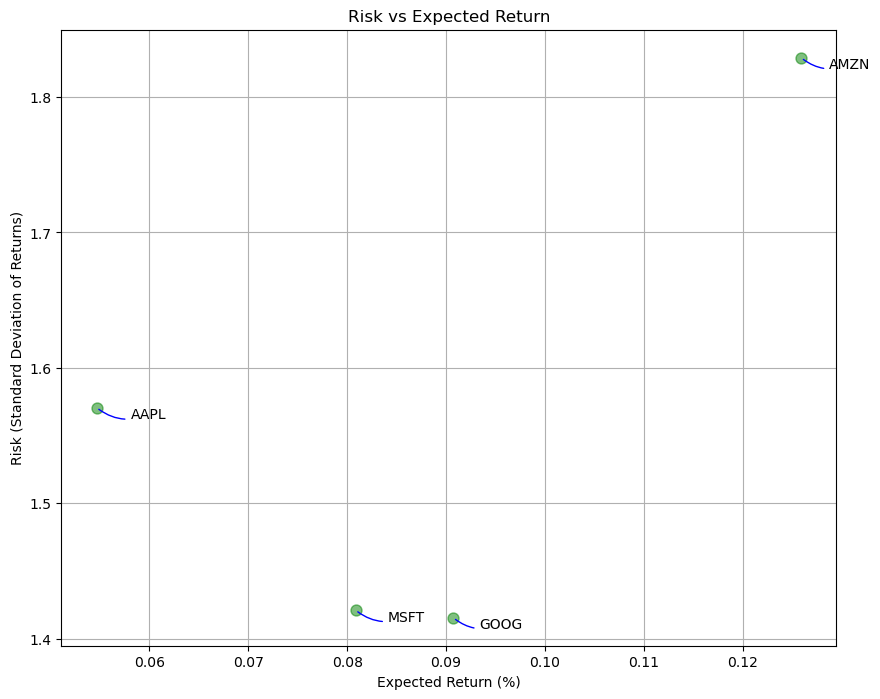

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate daily percentage returns for each stock
all_data['Daily Return'] = all_data.groupby('Stock_Symbol')['Close'].pct_change() * 100

# Compute the mean and standard deviation (risk and return) for each stock
rets = all_data.groupby('Stock_Symbol')['Daily Return'].agg(['mean', 'std']).rename(columns={'mean': 'Expected Return', 'std': 'Risk'})

# Scatter plot of risk vs. expected return
plt.figure(figsize=(10, 8))
area = np.pi * 20  # Size of scatter plot points
plt.scatter(rets['Expected Return'], rets['Risk'], s=area, alpha=0.5, color='green')

# Add labels and annotations
plt.xlabel('Expected Return (%)')
plt.ylabel('Risk (Standard Deviation of Returns)')
plt.title('Risk vs Expected Return')

# Annotate each stock
for label, x, y in zip(rets.index, rets['Expected Return'], rets['Risk']):
    plt.annotate(label, xy=(x, y), xytext=(50, -10), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

plt.grid(True)
plt.savefig('Risk')
plt.show()
